# Procesamiento Digital de Audio
## Caleb Rascón
### Separación de Fuentes en Línea


#### GSC - Generalized Sidelobe Canceller with Dynamic Mu

In [3]:
#Bibliotecas
import numpy as np
from numpy import pi
from numpy.fft import fft, ifft
from matplotlib import pyplot as plt
from delay_f import delay_f
from trianglewave import trianglewave

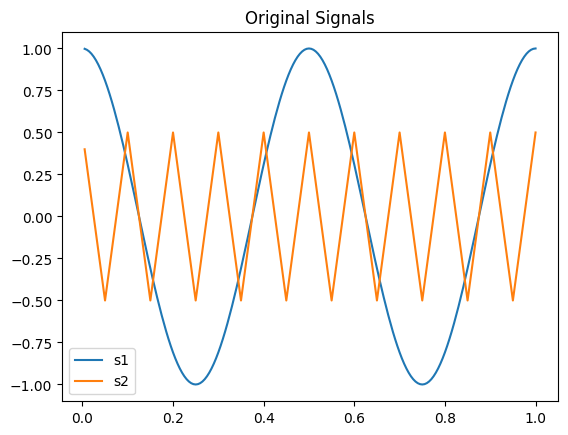

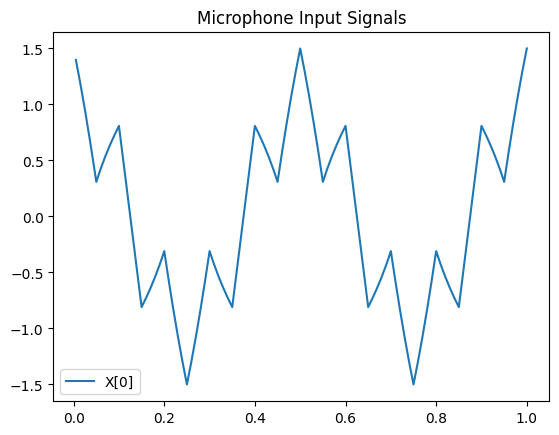

/tmp/ipykernel_50733/4176502998.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  if mu0 * p_x_n / p_o < mu_max:


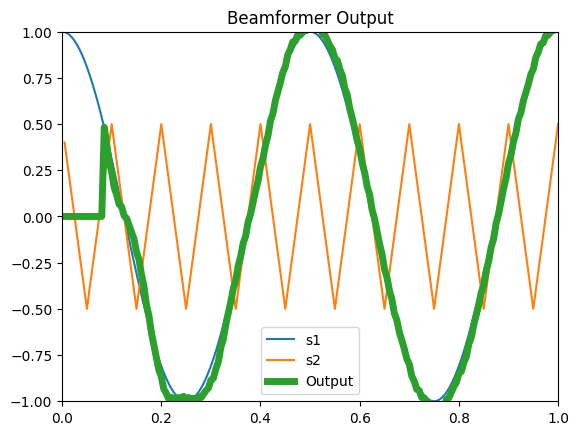

In [6]:
# Parameters
doa1 = 20 * np.pi / 180  # Direction of arrival of first signal
doa2 = -40 * np.pi / 180  # Direction of arrival of second signal
doa_steer = doa1  # Direction to steer the beamformer
d = 4  # Distance between microphones in meters
M = 8  # Number of microphones
mu0 = 0.01  # Base adaptation rate
mu_max = 0.0001  # Maximum adaptation rate
N = 200  # Signal size in samples

# Simulating signals
t = np.arange(1, N + 1) / N  # Time vector (1 second)
c = 343  # Speed of sound
fs = N  # Sampling frequency same as signal size (1 second)

# Original signals
s1 = np.cos(2 * np.pi * 2 * t)
s2 = trianglewave(10, N) * 0.5

plt.figure(1)
plt.plot(t, s1, label='s1')
plt.plot(t, s2, label='s2')
plt.legend()
plt.title('Original Signals')
plt.show()

# Microphones (input signals)
X = np.zeros((M, N))
X[0, :] = s1 + s2
for m in range(1, M):
    X[m, :] = delay_f(s1, (m * d / c) * np.sin(doa1), N) + delay_f(s2, (m * d / c) * np.sin(doa2), N)

plt.figure(2)
plt.plot(t, X[0, :], label='X[0]')
plt.legend()
plt.title('Microphone Input Signals')
plt.show()

# Applying the appropriate delays to input signals
for m in range(1, M):
    X[m, :] = delay_f(X[m, :], -(m * d / c) * np.sin(doa_steer), N)

# Calculating the upper part of GSC
y_u = np.sum(X, axis=0) / M

# Calculating the lower part
x_n = np.zeros((M-1, N))
for m in range(M-1):
    x_n[m, :] = X[m+1, :] - X[m, :]

# Applying beamformer
Nw = 16
o = np.zeros(N)
g = np.zeros((M-1, Nw))
mu = 0

for k in range(Nw, N):
    this_y_u = y_u[k]

    this_x_n = x_n[:, k-Nw:k]

    this_y_n = np.sum(np.sum(g * this_x_n, axis=1))

    o[k] = this_y_u - this_y_n

    this_o = o[k-Nw:k]

    # Calculating output power
    p_o = np.sum(this_o**2)

    # Updating filter (one mu per input)
    for m in range(M-1):
        # Calculating noise power
        p_x_n = np.sum(this_x_n[m, :]**2)

        if mu0 * p_x_n / p_o < mu_max:
            mu = mu0 / p_o
        else:
            mu = mu0 / p_x_n

        g[m, :] = g[m, :] + mu * o[k] * this_x_n[m, :]

plt.figure(3)
plt.plot(t, s1, label='s1')
plt.plot(t, s2, label='s2')
plt.plot(t, o, linewidth=5, label='Output')
plt.legend()
plt.title('Beamformer Output')
plt.axis([0, 1, -1, 1])
plt.show()
